In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jul 13 13:13:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install tensorflow==2.4.1
!pip install tensorflow-quantum==0.5.1

from IPython.display import clear_output
clear_output()

In [9]:
import sys
sys.version

'3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]'

In [10]:
# main dependencies
import tensorflow as tf  # 2.4.1
import tensorflow_quantum as tfq  # 0.5.1
import cirq  # 0.11.0
import sympy  # 1.5
import numpy as np  # 1.19.5
from functools import reduce

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load saved weights
import h5py

import os

## Loading the Dataset

In [11]:
with h5py.File("/content/drive/My Drive/Projects/GSoC 2021/electron-photon-dataset/photon.hdf5", "r") as f:
  px = np.asarray(f['X'][()], dtype=np.float32)
  py = np.asarray(f['y'][()], dtype=np.float32)
  print("Loaded photon dataset!")

with h5py.File("/content/drive/My Drive/Projects/GSoC 2021/electron-photon-dataset/electron.hdf5", "r") as f:
  ex = np.asarray(f['X'][()], dtype=np.float32)
  ey = np.asarray(f['y'][()], dtype=np.float32)
  print("Loaded electron dataset!")

print("Photon dataset shape:", px.shape, py.shape)
print("Electron dataset shape:", ex.shape, ey.shape)

Loaded photon dataset!
Loaded electron dataset!
Photon dataset shape: (249000, 32, 32, 2) (249000,)
Electron dataset shape: (249000, 32, 32, 2) (249000,)


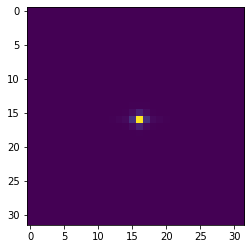

In [12]:
# photon average image

plt.imshow(np.mean(px[:, :, :, 0], axis=0))

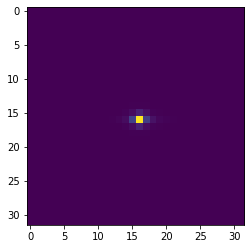

In [13]:
# electron average image

plt.imshow(np.mean(ex[:, :, :, 0], axis=0))

In [14]:
max_photon, min_photon = np.max(px[:, :, :, 0]), np.min(px[:, :, :, 0])
max_electron, min_electron = np.max(ex[:, :, :, 0]), np.min(ex[:, :, :, 0])

print(max_photon, min_photon)
print(max_electron, min_electron)
max(max_photon, abs(min_photon), max_electron, abs(min_electron))

1.4849443 0.0
1.431813 0.0


1.4849443

In [15]:
sample_size = 10000

X = np.concatenate((px[:, :, :, 0], ex[:, :, :, 0]), axis=0)
y = np.concatenate((py[:], ey[:]), axis=0)

_, X, _, y = train_test_split(X, y, test_size=sample_size, random_state=88)

print(X.shape, y.shape)

(10000, 32, 32) (10000,)


## Dataset Preprocessing

Position of maximum value pixel.

In [16]:
print("Proton:", np.argmax(np.mean(px[:, :, :, 0], axis=0)))
print("Electron:", np.argmax(np.mean(ex[:, :, :, 0], axis=0)))

Proton: 528
Electron: 528


Crop from 32x32 to 8x8, maintaining the maximum value pixel at the center.

In [17]:
center = [int(528/32), 528%32]

img_size = 8

X = X[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
X.shape

(10000, 8, 8)

Train-Test Split.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2021)

y_train = tf.keras.utils.to_categorical(y_train)

y_test = tf.keras.utils.to_categorical(y_test)

print("Train set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Train set shape: (8500, 8, 8) (8500, 2)
Test set shape: (1500, 8, 8) (1500, 2)


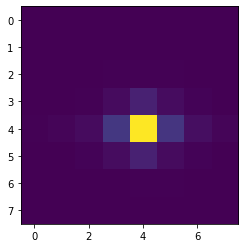

In [19]:
# photon average image

plt.imshow(np.mean(X[:int(len(X)/2), :, :], axis=0))

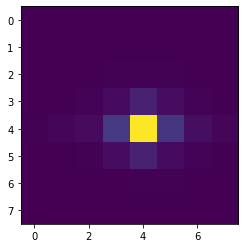

In [20]:
# electron average image

plt.imshow(np.mean(X[int(len(X)/2):, :, :], axis=0))

In [ ]:
del px, py, ex, ey

## Graph-Convolution Preprocessing

### Adjacency Matrix

In [ ]:
img_size = 32
adjacency = np.zeros((img_size**2, img_size**2), dtype=np.float64)
gaussian_scale = np.pi

# k = y-axis of the A matrix
# i = y-axis of the image
# j = x-axis of the image
for k in range(img_size**2):
    for i in range(img_size):
        for j in range(img_size):
            x_1 = k%img_size  # x coordinate of the pixel-k in the A matrix
            x_2 = j  # x coordinate of the image

            y_1 = int(k/img_size)  # y coordinate of the pixel-k in the A matrix
            y_2 = i  # y coordinate of the image

            adjacency[k, i*img_size + j] = np.exp(-np.sqrt((x_1-x_2)**2 + (y_1-y_2)**2)/(gaussian_scale**2))

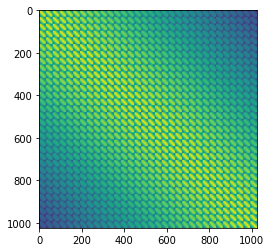

In [ ]:
plt.imshow(np.log10(adjacency))

### Average Plot of A^2 X

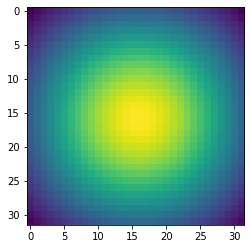

In [ ]:
# photon

plt.imshow((adjacency@adjacency@(np.mean(px[:, :, :, 0], axis=0).reshape(-1,))).reshape(32,32))

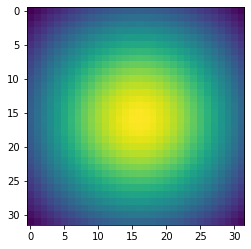

In [ ]:
# electron

plt.imshow((adjacency@adjacency@(np.mean(ex[:, :, :, 0], axis=0).reshape(-1,))).reshape(32,32))

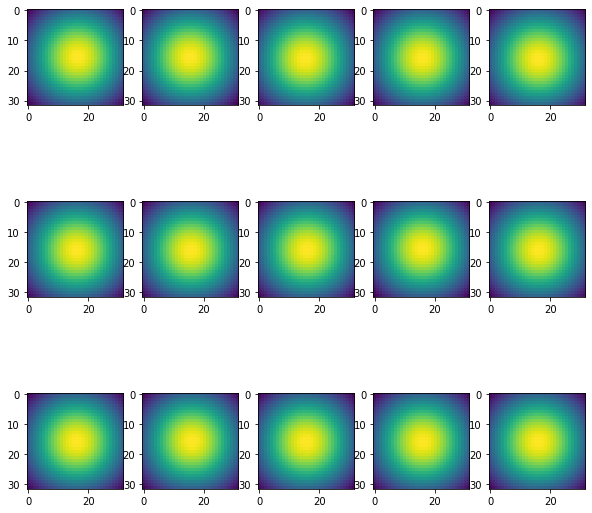

In [ ]:
# photon

fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 3
random_integer = np.random.randint(0, high=len(px), size=columns*rows)
for i in range(1, columns*rows +1):
    img = (adjacency@adjacency@px[random_integer[i-1], :, :, 0].reshape(-1,)).reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='viridis')
plt.show()

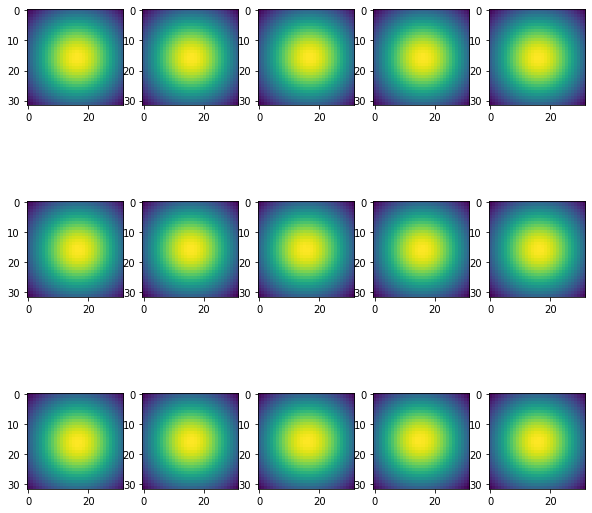

In [ ]:
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 3
random_integer = np.random.randint(0, high=len(ex), size=columns*rows)
for i in range(1, columns*rows +1):
    img = (adjacency@adjacency@(ex[random_integer[i-1], :, :, 0].reshape(-1,))).reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='viridis')
plt.show()

## Building the Networks

In [21]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]


In [22]:
def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cx_ops = [cirq.CX(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cx_ops += ([cirq.CX(qubits[-1], qubits[0])] if len(qubits) != 2 else [])
    return cx_ops

In [23]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for weights and bias parameters
    params = sympy.symbols(f'theta(0:{n_qubits*n_layers*3})')
    params = np.asarray(params).reshape((n_layers, 3, n_qubits))

    # Sympy symbols for input features
    inputs = sympy.symbols(f'x(0:{2*n_qubits})')
    inputs = np.asarray(inputs).reshape((2, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()

    # Encoding layer
    for q in range(n_qubits):
        circuit += cirq.Circuit([cirq.ry(inputs[0, q])(qubits[q]), cirq.rz(inputs[1, q])(qubits[q])])

    # Variational layer
    for l in range(n_layers):
        circuit += entangling_layer(qubits)
        for q in range(n_qubits):
            circuit += cirq.Circuit(one_qubit_rotation(qubits[q], params[l, :, q]))

    return circuit, list(params.flat), list(inputs.flat)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


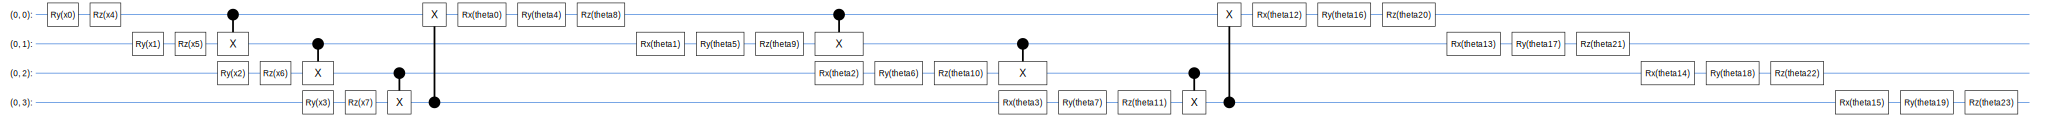

In [24]:
filter_size = 2

n_qubits, n_layers = filter_size*filter_size, 2

qubits = cirq.GridQubit.rect(1, n_qubits)
observables = [cirq.Z(qubits[0])] # Measure only the first qubit

# generate the circuit
circuit, theta_sym, inputs_sym = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

In [25]:
class ConvKernelPQC(tf.keras.layers.Layer):
    def __init__(self, n_layers, filter_size, name="ConvKernel_PQC"):
        super(ConvKernelPQC, self).__init__(name=name)

        self.n_layers = n_layers
        self.filter_size = filter_size
        self.main_name = name

        self.n_qubits = filter_size*filter_size
        self.qubits = cirq.GridQubit.rect(1, self.n_qubits)
        self.observables = [cirq.Z(self.qubits[0])]  # Measure only the first qubit

        # generate the circuit
        circuit, theta_symbols, input_symbols = generate_circuit(self.qubits, self.n_layers)

        # define explicit symbol order
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])

        # thetas (trainable parameters) initialization
        thetas_init = tf.random_uniform_initializer(minval=-np.pi/2, maxval=np.pi/2)
        self.thetas = tf.Variable(
            initial_value=thetas_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-thetas"
        )

        # dummy inputs initialization
        # using the empty circuits as hacks for ControlledPQC
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

        self.computation_layer = tfq.layers.ControlledPQC(circuit, self.observables)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_layers': self.n_layers,
            'filter_size': self.filter_size,
            'name': self.main_name
        })
        return config
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # flatten inputs (from 2D images to 1D array)
        inputs_flattened = tf.keras.layers.Flatten()(inputs)

        # convert input x to arctan of x and arctan of x^2
        inputs_x = tf.math.atan(inputs_flattened)
        inputs_x2 = tf.math.atan(tf.math.square(inputs_flattened))
        
        # duplicate parameters and dummy inputs
        # one for every batch
        thetas_batch = tf.tile(self.thetas, multiples=[batch_size, 1], name=self.main_name + '-tiled_up_thetas')
        empty_circuit_batch = tf.repeat(self.empty_circuit, repeats=batch_size, name=self.main_name + '-tiled_up_empty_circuits')

        joined_params = tf.concat([thetas_batch, inputs_x, inputs_x2], axis=-1)
        joined_params = tf.gather(joined_params, self.indices, axis=-1, name=self.main_name + '-joined_params')

        return self.computation_layer([empty_circuit_batch, joined_params])

In [26]:
def QConv_layer(n_layers, filter_size, stride, inputs, conv_id='', name="QConv_layer"):
    iter = int(1+(inputs.shape[1]-filter_size)/stride)

    pqc = ConvKernelPQC(n_layers, filter_size, name=name+conv_id)
    conv = []
    for i in range(iter):
        for j in range(iter):
            temp = pqc(inputs[:, stride*i:stride*i+filter_size, stride*j:stride*j+filter_size])
            conv += [temp]
    output_concat = tf.keras.layers.Concatenate(axis=1)(conv)
    output_reshape = tf.keras.layers.Reshape((iter, iter))(output_concat)

    return output_reshape

In [30]:
filter_size = 3
stride = 1

int(1+(8-filter_size)/stride)

6

In [31]:
n_layers = 2

input_tensor = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2], ), dtype=tf.dtypes.float32, name='input')

filter_size = [3, 2]
stride = [1, 1]

conv_1 = QConv_layer(n_layers, filter_size[0], stride[0], input_tensor, conv_id='1')
#reshape_1_1 = tf.keras.layers.Reshape((conv_1.shape[1], conv_1.shape[2], 1))(conv_1)
#max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, name='Max_Pool_Layer_1')(reshape_1_1)
#reshape_1_2 = tf.keras.layers.Reshape((max_pool_1.shape[1], max_pool_1.shape[2]))(max_pool_1)


conv_2 = QConv_layer(n_layers, filter_size[1], stride[1], conv_1, conv_id='2')
#reshape_2_1 = tf.keras.layers.Reshape((conv_2.shape[1], conv_2.shape[2], 1))(conv_2)
#max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, name='Max_Pool_Layer_2')(reshape_2_1)
#reshape_2_2 = tf.keras.layers.Reshape((max_pool_2.shape[1], max_pool_2.shape[2]))(max_pool_2)

conv_output = tf.keras.layers.Flatten()(conv_2)

dense_1 = tf.keras.layers.Dense(8, activation='relu')(conv_output)
dense_2 = tf.keras.layers.Dense(2, activation='softmax')(dense_1)

model = tf.keras.Model(inputs=[input_tensor], outputs=dense_2)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 3, 3)         0           input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 3, 3)         0           input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 3, 3)         0           input[0][0]                      
______________________________________________________________________________________________

In [33]:
model(x_train[0:3])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.51697046, 0.48302954],
       [0.515318  , 0.48468205],
       [0.516762  , 0.48323795]], dtype=float32)>

In [34]:
# Training parameters
BATCH_SIZE = 128  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200

# Print parameters for sanity check
print("Batch size, epochs:", BATCH_SIZE, EPOCHS)

Batch size, epochs: 128 200


In [35]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [36]:
opt_adam = tf.keras.optimizers.Adam(lr=lr_schedule(0))

Learning rate:  0.001


In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt_adam,
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [38]:
checkpoint_dir = '/content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/v3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=opt_adam,
                                 model=model)

class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        checkpoint.save(file_prefix = checkpoint_prefix)
        print("Saved custom checkpoint for epoch {}.".format(epoch + 1))

In [39]:
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

cp_filepath = "/content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCNN_Type1_L1Q3_10000samples-{epoch:02d}epoch.h5"
checkpoint_callback_epoch = tf.keras.callbacks.ModelCheckpoint(
    cp_filepath, monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=True, mode='auto', save_freq='epoch'
)

callbacks = [lr_reducer, lr_scheduler, checkpoint_callback_epoch, CustomCallback()]

In [ ]:
import time
#start_time = time.time()

last_epoch = 0

H = model.fit(x_train, y_train, initial_epoch=last_epoch,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

print(H.history)

Epoch 1/200
Learning rate:  0.001
67/67 [==============================] - 588s 8s/step - loss: 0.6932 - accuracy: 0.5036 - auc: 0.5064 - val_loss: 0.6928 - val_accuracy: 0.5593 - val_auc: 0.5246

Epoch 00001: saving model to /content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCNN_Type1_L1Q3_10000samples-01epoch.h5
Saved custom checkpoint for epoch 1.
Epoch 2/200
Learning rate:  0.001
67/67 [==============================] - 563s 8s/step - loss: 0.6928 - accuracy: 0.5059 - auc: 0.5165 - val_loss: 0.6927 - val_accuracy: 0.5213 - val_auc: 0.5278

Epoch 00002: saving model to /content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCNN_Type1_L1Q3_10000samples-02epoch.h5
Saved custom checkpoint for epoch 2.
Epoch 3/200
Learning rate:  0.001
67/67 [==============================] - 565s 8s/step - loss: 0.6925 - accuracy: 0.5346 - auc: 0.5413 - val_loss: 0.6924 - val_accuracy: 0.5627 - val_auc: 0.5625

Epoch 00003: saving model to /content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCN

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import time
#start_time = time.time()

last_epoch = 188

H = model.fit(x_train, y_train, initial_epoch=last_epoch,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

print(H.history)

Epoch 189/200
Learning rate:  5e-07
67/67 [==============================] - 783s 11s/step - loss: 0.6439 - accuracy: 0.6281 - auc: 0.6742 - val_loss: 0.6595 - val_accuracy: 0.6273 - val_auc: 0.6542

Epoch 00189: saving model to /content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCNN_Type1_L1Q3_10000samples-189epoch.h5
Saved custom checkpoint for epoch 188.
Epoch 190/200
Learning rate:  5e-07
67/67 [==============================] - 729s 11s/step - loss: 0.6384 - accuracy: 0.6340 - auc: 0.6843 - val_loss: 0.6595 - val_accuracy: 0.6273 - val_auc: 0.6542

Epoch 00190: saving model to /content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCNN_Type1_L1Q3_10000samples-190epoch.h5
Saved custom checkpoint for epoch 189.
Epoch 191/200
Learning rate:  5e-07
67/67 [==============================] - 698s 10s/step - loss: 0.6438 - accuracy: 0.6263 - auc: 0.6749 - val_loss: 0.6595 - val_accuracy: 0.6273 - val_auc: 0.6542

Epoch 00191: saving model to /content/drive/MyDrive/Projects/GSoC 2021/M

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import time
#start_time = time.time()

last_epoch = 199

H = model.fit(x_train, y_train, initial_epoch=last_epoch,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

print(H.history)

Epoch 200/200
Learning rate:  5e-07
67/67 [==============================] - 786s 11s/step - loss: 0.6425 - accuracy: 0.6307 - auc: 0.6772 - val_loss: 0.6595 - val_accuracy: 0.6273 - val_auc: 0.6542

Epoch 00200: saving model to /content/drive/MyDrive/Projects/GSoC 2021/Model_Hybrid/QCNN_Type1_L1Q3_10000samples-200epoch.h5
Saved custom checkpoint for epoch 199.
{'loss': [0.6415966749191284], 'accuracy': [0.6310588121414185], 'auc': [0.6788457632064819], 'val_loss': [0.6594995260238647], 'val_accuracy': [0.6273333430290222], 'val_auc': [0.65424644947052], 'lr': [5e-07]}


In [ ]:
L1: 